[Chapter 6] Fine-tunning for classification

preparing the dataset

In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
    url, zip_path, extracted_path, data_file_path):

    if data_file_path.exists():
        print(f"{data_file_path} already exists. skipping download "
                "and extraction.")
        return
    
    # download the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    
    # unzip the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    # add a .tsv file extension
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")


# execution
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. skipping download and extraction.


In [2]:
# load dataset
import pandas as pd

df = pd.read_csv(data_file_path, sep='\t', header=None, names=['Label','Text'])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
# class label distribution
print(df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
# undersample and create a balanced dataset

def create_balanced_dataset(df):
    # counts the instance of spam
    num_spam = df[df['Label'] == 'spam'].shape[0]
    # randomly samples the "ham" instances to match the num of "spam" instances
    ham_subset = df[df['Label'] == 'ham'].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df['Label']=='spam']])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df['Label'].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
# convert string class labels into integer class labels 0 and 1
balanced_df['Label'] = balanced_df['Label'].map({"ham": 0, "spam": 1})

In [6]:
# split the dataset 
# (70% for training, 10% for validation, 20% for testing, common ratios in machine learning to train, adjust and evaluate models)

def random_split(df, train_frac, validation_frac):

    # shuffle the entire dataset
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    # calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # split the dataframe
    train_df = df[:train_end]
    validation_df = df[train_end: validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

# execution
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

# save data
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

creating data loaders

In [7]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

# 50256 will be used to pad the token ids to the longest sequence (as padded token ids)

[50256]


In [8]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        # pretokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]
        
        # pad sequence to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] *
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        
        return max_length

In [9]:
train_dataset = SpamDataset(
    csv_file = "train.csv",
    max_length = None,
    tokenizer = tokenizer
)

# num of tokens in the longest sequence
# model can handle sequences of up to 1024 tokens given context length limit
print(train_dataset.max_length)

120


In [10]:
# pad the validation and test sets to match the length of the longest training sequence
# any validation and test set samples exceeding the length of the longest training example are truncated
# truncation can be optional if max_length=None

val_dataset = SpamDataset(
    csv_file = "validation.csv",
    max_length = train_dataset.max_length,
    tokenizer = tokenizer
)

test_dataset = SpamDataset(
    csv_file = "test.csv",
    max_length = train_dataset.max_length,
    tokenizer = tokenizer
)

In [11]:
from torch.utils.data import DataLoader

# this setting ensures compatibility with most computers
num_workers = 0
batch_size = 8 # each batch will consist of 8 training examples
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [12]:
for input_batch, target_batch in train_loader:
    pass

print("input batch dimensions:", input_batch.shape)
print("label batch dimensions:", target_batch.shape)

input batch dimensions: torch.Size([8, 120])
label batch dimensions: torch.Size([8])


In [13]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


initializing a model with pretrained weights

In [14]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,   # dropout rate
    "qkv_bias": True    # query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (744M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-x1 (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBac

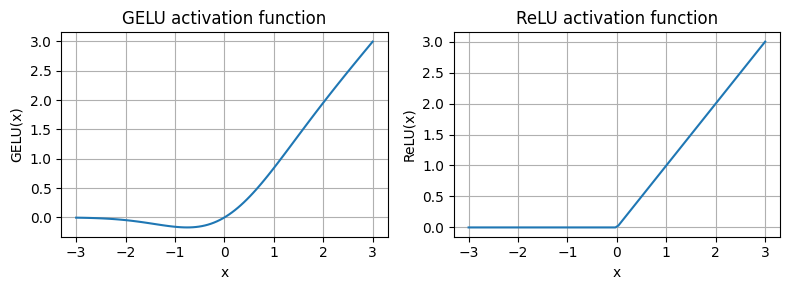

torch.Size([2, 3, 768])
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606
layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
tensor([0.5500, 0.8700, 0.6600])---->tenso

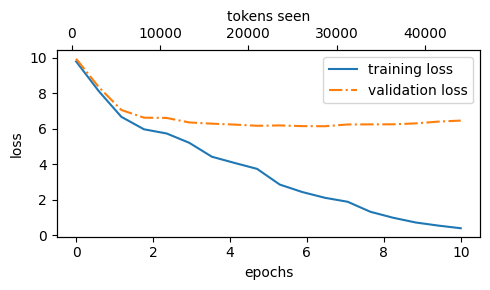

output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun
forward
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


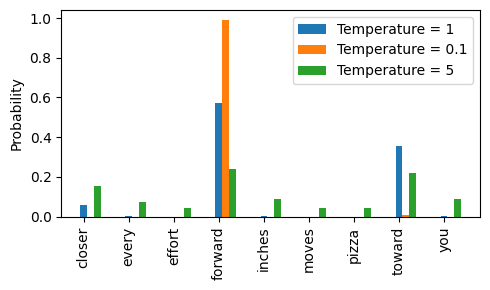

top logits: tensor([6.7500, 6.2800, 4.5100])
top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])
output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-
File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
setttings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [15]:
# load a pretrained gpt model
from gpt_download import download_and_load_gpt2

import import_ipynb
from ch5 import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir='gpt2'
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

In [16]:
from ch4 import generate_text_simple
from ch5 import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [17]:
# check whether the model already classifies spam message by prompting it with instructions

text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    "'You are a winner you have been specially "
    "selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

# the model struggles to follow the instruction. It is expected as it has nly undergone pretraining and lacks instruction fine-tunning.

Is the following text 'spam'? Answer with 'yes' or 'no':'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no':'You are a winner


In [18]:
# print model architecture
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [19]:
# freeze the model: make all layers nontrainable
for params in model.parameters():
    params.requires_grad=False

In [20]:
# add a classification layer
torch.manual_seed(123)
num_classes = 2
# model.out_head output layer has its requires_grad=True by default
#                which means it's the only layer in the model that will be updated during training
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], # 768 in gpt-small model
    out_features=num_classes
)

In [21]:
# to make the final layernorm and last transformer block trainable
for param in model.trf_blocks[-1].parameters():
    param.requires_grad=True
for param in model.final_norm.parameters():
    param.requires_grad=True

In [22]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:",inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [23]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)
# each output's embedding dimension (# columns) is now 2 intead of 50257 since we replaced the output layer of the model

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [ ]:
print("Last output token:", outputs[:, -1, :])
# the last token: given the causal attention mask setup, the last token in a sequence accmulates the most info
#                 since it is the only token with access to data from all the previous tokens 
#                 focus on this last token during the fine-tuning process

Last output token: tensor([[-3.5983,  3.9902]])


calculating the classification loss and accuracy

In [26]:
# concrete example
print("last output token:", outputs[:,-1,:])

last output token: tensor([[-3.5983,  3.9902]])


In [28]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("class label:", label.item())

# using softmax here is optional because the largest outputs directly correspond to the highest prob scores (given binary)
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("class label:", label.item())

class label: 1
class label: 1


In [33]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
        else:
            break
    
    return correct_predictions / num_examples

In [ ]:
# execution, estimated from 10 batches
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"training accuracy: {train_accuracy*100:.2f}%")
print(f"validation accuracy: {val_accuracy*100:.2f}%")
print(f"test accuracy: {test_accuracy*100:.2f}%")

# the prediction accuracies are near a random prediction (close to 50% in this case)
# to improve the prediction, we need to finetune the model

training accuracy: 46.25%
validation accuracy: 45.00%
test accuracy: 48.75%


In [39]:
# define loss function to optmize during the training before fine-tunning the model
# given classification accuracy is not a differentiable function, cross-entropy loss as a proxy to maxmize accuracy
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    # logits of last output token
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [40]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # ensure num_batches doesn't exceed batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [41]:
# calculate the initial loss values

with torch.no_grad(): # disable gradient tracking for efficiency because we are not training yet
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"training loss: {train_loss:.3f}")
print(f"validation loss: {val_loss:.3f}")
print(f"test loss: {test_loss:.3f}")

training loss: 3.211
validation loss: 2.583
test loss: 2.322


fine-tune the model on supervised data

In [43]:
# fine-tune the model, which means adjust the model to minimize the training set loss
def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # main training loop
    for epoch in range(num_epochs):
        # set model to training mode
        model.train()
        
        for input_batch, target_batch in train_loader:
            # reset loss gradients from the previous batch iteration
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            # calculate loss gradients
            loss.backward()
            # update model weights using loss gradients
            optimizer.step()
            # new: tracks examples instead of tokens
            examples_seen += input_batch.shape[0]
            global_step += 1

            # optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}")

        # calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

        print(f"training accuracy: {train_accuracy*100:.2f}% | ", end ="")
        print(f"validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss    

In [44]:
# initialize the optimizer and initiate the training

import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5
    )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"training completed in {execution_time_minutes:.2f} minutes")


Ep 1 (Step 000000): Train loss 2.153,Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617,Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523,Val loss 0.557
training accuracy: 70.00% | validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561,Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419,Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409,Val loss 0.353
training accuracy: 82.50% | validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333,Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340,Val loss 0.306
training accuracy: 90.00% | validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136,Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153,Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222,Val loss 0.137
training accuracy: 100.00% | validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207,Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083,Val loss 0.074
training accuracy: 100.00% | validation accuracy: 97.50%
training completed in 51.32 minutes


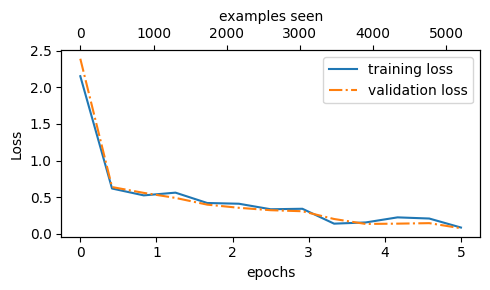

In [51]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label='loss'):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle='-.',
        label=f"validation {label}"
    )
    ax1.set_xlabel("epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # create a second x-axis for examples seen
    ax2 = ax1.twiny()
    # invisible plot for aligning ticks
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

# model is learning well from the training data (given he sharpe downward slope)
# little to no indication of overfitting (given no noticable gap between the training and validation set losses)

# num of epochs: depends on dataset and task difficulty
#                5 is a good starting point, in this case, 5 is reasonable given no signs of early overfitting and ~0 validatio loss
#                if overfits need to reduce num of epochs
#                if trend suggest validation improve training, could increase num of epoch

In [66]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"training accuracy: {train_accuracy*100:.2f}%")
print(f"validation accuracy: {val_accuracy*100:.2f}%")
print(f"test accuracy: {test_accuracy*100:.2f}%")

# training vs test: slight discrepancy suggests minimal overfitting of the training data
# validation accuracy: typically higher than the test because the model development 
#                      often invovles tunning hyperparameters to perform well on the validation set (not generalize on test set)

training accuracy: 97.21%
validation accuracy: 97.32%
test accuracy: 95.67%


In [67]:
def classify_review(
        text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    
    model.eval()

    # prepare input to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # truncate sequences if they are too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # pad sequence to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    # add batch dimension
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    # model inference without gradient tracking
    with torch.no_grad():
        # logits of the last output token
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam" # return the classified result
    

In [72]:
# execution

text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [73]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [ ]:
# save model (trained)

torch.save(model.state_dict(), "review_classifier.pth")

In [ ]:
# load model

model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>